# Unsupervised Clustering 
I will be doing that by encoding the images through a trained convolutional network, and then apply a clustering algorithm to the encoded features. We can then check the clusters and see if it worked!

In [2]:

import time
import os, os.path
import random
import cv2
import glob
import keras
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# REUSABLE FUNCTIONS 



### Load dataset

In [3]:
import os
import pandas as pd

script_dir = os.path.dirname(os.path.abspath("capstone.py",))
os.chdir(script_dir)
# Directory where images are stored
DIR = "./wasteimage"

def dataset_stats(waste_types):
    # Dictionary where we will store the stats
    stats = []
    
    for waste_type in waste_types:
        # Construct the path to the subdirectory
        sub_directory = os.path.join(DIR, waste_type)
        
        # Get list of file names in the subdirectory
        file_names = [file for file in os.listdir(sub_directory) if os.path.isfile(os.path.join(sub_directory, file))]
        file_count = len(file_names)
        sub_directory_name = os.path.basename(sub_directory)
        # Append stats to the list
        stats.append({
            "Code": sub_directory_name,
            "Image count": file_count, 
            "Folder name": os.path.basename(sub_directory),
            "File names": file_names
        })
    
    # Convert stats to a DataFrame
    df = pd.DataFrame(stats)
    
    return df

### Loading the images

Now we create a function that loads all images in a directory for a given array of codes in one array and creates the corresponding label array for them.

Loaded images are resized to 224 x 224 before storing them in our array since this is the size preferred by VGG19 which we will be using later.

In [4]:
def load_images(codes,dataset):
    
    # Define empty arrays where we will store our images and labels
    images = []
    labels = []
    
    for code in codes:
        # get the folder name for this code
        folder_name = dataset.loc[code]["Folder name"]
        
        for file in dataset.loc[code]["File names"]:                 
            # build file path
            file_path = os.path.join(DIR, folder_name, file)
        
            # Read the image
            image = cv2.imread(file_path)

            # Resize it to 224 x 224
            image = cv2.resize(image, (224,224))

            # Convert it from BGR to RGB so we can plot them later (because openCV reads images as BGR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Now we add it to our array
            images.append(image)
            labels.append(code)

    return images, labels

In [5]:
def show_random_images(images, labels, number_of_images_to_show=2):

    for code in list(set(labels)):

        indicies = [i for i, label in enumerate(labels) if label == code]
        random_indicies = [random.choice(indicies) for i in range(number_of_images_to_show)]
        figure, axis = plt.subplots(1, number_of_images_to_show)

        print("{} random images for code {}".format(number_of_images_to_show, code))

        for image in range(number_of_images_to_show):
            axis[image].imshow(images[random_indicies[image]])
        plt.show()

## PREPROCESSING DATA
### Normalise (constrast enhancement)

We now convert the images and labels to NumPy arrays to make processing them easier. We then normalise the images before passing them on to VGG19

In [6]:
def normalise_images(images, labels):

    # Convert to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)

    # Normalise the images
    images /= 255
    
    return images, labels

### Split dataset

Now that we have all the photos and their labels in arrays. It's time to shuffle them around, and split them to three different sets... training, validation and testing.

We'll be using the `train_test_split` function from sklearn which will also shuffle the data around for us, since it's currently in order.

In [7]:
from sklearn.model_selection import train_test_split
def shuffle_data(images, labels):
    #chi dung de shuffle randomly data
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.0000001, random_state=728)
    
    return images, labels

### Load pre-trained covnet models for FEATURE EXTRACTION
#### VGG16, VG19, ResNet50

We'll now load up the keras models with the imagenet weights. We'll remove the top dense layers, since we won't need to classify things here, and we just want these encoded features from the images.

In [8]:
# Load the models with ImageNet weights for extracting image features for futher tasks(like object detection or image classi)
#USED/RUN separately,INDEPENDENTLY for the same task
vgg16_model = keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3)) 

vgg19_model = keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=(224,224,3)) #a variant of VGG16 with three additional convolutional layers.

resnet50_model = keras.applications.resnet50.ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3)) #3 color channels RGB

### feature extraction=> feature arrays


The covnet models will give us 3D vectors that represent the image. We need to flatten these for the clustering algorithms to start working with them.

In [9]:
def covnet_transform(covnet_model, raw_images):

    # Pass raw images => a set of feature maps (3d array) detected by the models
    pred = covnet_model.predict(raw_images)

    # Flatten the array 3D=>2D
    flat = pred.reshape(raw_images.shape[0], -1)
    #(100, 7, 7, 512) representing 100 images, each with 7x7 feature maps of depth 512
    # => (100, 25088), where each row represents an image and each column represents a feature
    return flat


### PCA(dimensionality reduction)

In [10]:
# Function that creates a PCA instance, fits it to the data and returns the instance
from sklearn.decomposition import PCA
def create_fit_PCA(data, n_components=None):
    
    p = PCA(n_components=n_components, random_state=728)
    p.fit(data)
    
    return p
    

In [11]:
# Function to plot the cumulative explained variance of PCA components
# This will help us decide how many components we should reduce our features to
def pca_cumsum_plot(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

## CLUSTERING ON EACH FEATURE EXTRATOR MODELS



In [12]:
from sklearn.cluster import KMeans
def create_train_kmeans(data, number_of_clusters):
    
    k = KMeans(n_clusters=number_of_clusters, random_state=728)

    # Let's do some timings to see how long it takes to train.
    start = time.time()

    # Train it up
    k.fit(data)

    # Stop the timing 
    end = time.time()

    # And see how long that took
    print("Training took {} seconds".format(end-start))
    
    return k

In [13]:
def cluster_label_count(clusters, labels):
    
    count = {}
    
    # Get unique clusters and labels
    unique_clusters = list(set(clusters))
    unique_labels = list(set(labels))
    
    # Create counter for each cluster/label combination and set it to 0
    for cluster in unique_clusters:
        count[cluster] = {}
        
        for label in unique_labels:
            count[cluster][label] = 0
    
    # Let's count
    for i in range(len(clusters)):
        count[clusters[i]][labels[i]] +=1
    
    cluster_df = pd.DataFrame(count)
    
    return cluster_df, count


#### LABEL ASSIGNMENT AND MODEL EVALUATION

In [14]:
from sklearn.metrics import silhouette_score, accuracy_score, f1_score
def get_max_label_per_cluster(cluster_count): 
    cluster_code = []
    for cluster in sorted(cluster_count.keys()):
        max_label = max(cluster_count[cluster], key=cluster_count[cluster].get)
        cluster_code.append(max_label)
    return cluster_code

def print_scores(true, pred):
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred, average="macro")
    return "\n\tF1 Score: {0:0.8f}  |   Accuracy: {1:0.8f}".format(f1, acc)

# TEST THE DATASET

In [15]:
# List the subfolders
folder = ['plant', 'food', 'paper', "carton", "glass bottle", "plastic bottle"] 

# Generate the dataset statistics
dataset = dataset_stats(waste_types= folder)

# Show codes with their folder names and image counts
dataset = dataset_stats(waste_types=folder).set_index("Code")
print(dataset[["Folder name", "Image count"]])

                   Folder name  Image count
Code                                       
plant                    plant          234
food                      food          308
paper                    paper          189
carton                  carton           89
glass bottle      glass bottle           87
plastic bottle  plastic bottle           91


In [16]:
codes = ['plant', 'food', 'paper', "carton", "glass bottle", "plastic bottle"] 
images, labels = load_images(codes, dataset)

2 random images for code carton


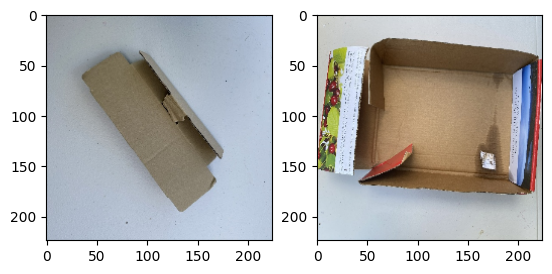

2 random images for code plant


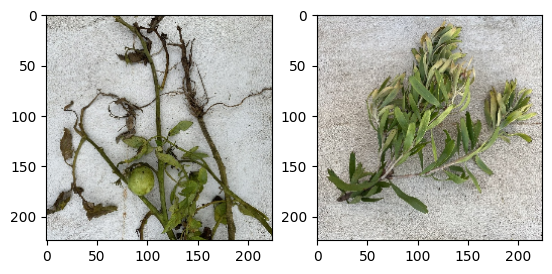

2 random images for code glass bottle


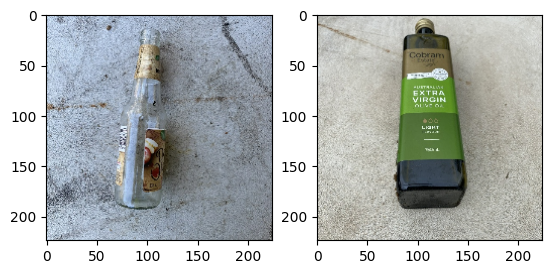

2 random images for code paper


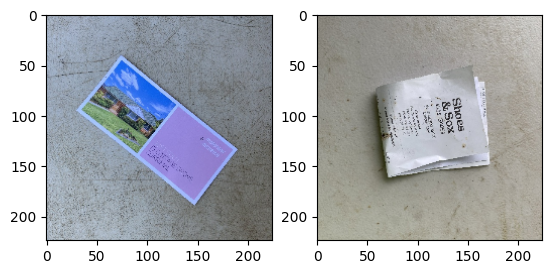

2 random images for code plastic bottle


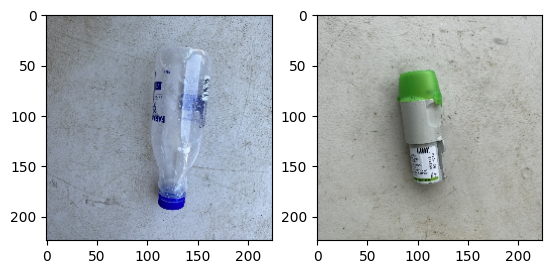

2 random images for code food


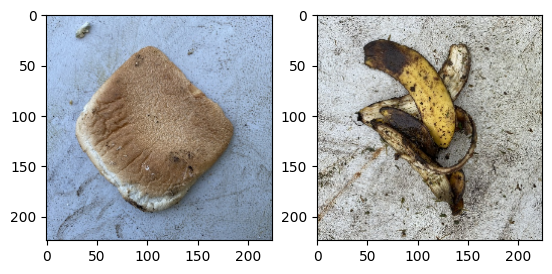

In [17]:

show_random_images(images, labels)

In [18]:
images, labels = normalise_images(images, labels)

In [19]:
X_train, y_train = shuffle_data(images, labels) 

In [20]:
vgg16_output = covnet_transform(vgg16_model, X_train)
print("VGG16 flattened output has {} features".format(vgg16_output.shape[1]))

vgg19_output = covnet_transform(vgg19_model, X_train)
print("VGG19 flattened output has {} features".format(vgg19_output.shape[1]))

resnet50_output = covnet_transform(resnet50_model, X_train)
print("ResNet50 flattened output has {} features".format(resnet50_output.shape[1]))

32/32 ━━━━━━━━━━━━━━━━━━━━ 130s 4s/step
VGG16 flattened output has 25088 features
32/32 ━━━━━━━━━━━━━━━━━━━━ 269s 8s/step
VGG19 flattened output has 25088 features
32/32 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step
ResNet50 flattened output has 100352 features


The above cell shows us the number of features each covnet gives to a single image. When we compare these to the original size of the image 224 x 224 x 3 = 150,528 pixels/features, we can see that this is a large reduction in what the clustering algorithms will have to work with.

CNNs are designed to gradually reduce the spatial dimensions (width and height) of the input through their layers while increasing the depth (number of feature maps). The idea is to capture the high-level features (like shapes, textures, or even whole objects) in the deeper layers of the network=> features can be reduced that much

Hopefully these reduces number of feature are represent more meaningful features in the image structure.

In [21]:
# Create PCA instances for each covnet output
vgg16_pca = create_fit_PCA(vgg16_output)
vgg19_pca = create_fit_PCA(vgg19_output)
resnet50_pca = create_fit_PCA(resnet50_output)


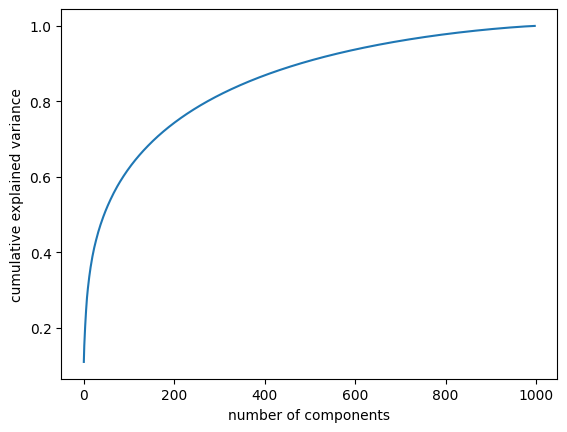

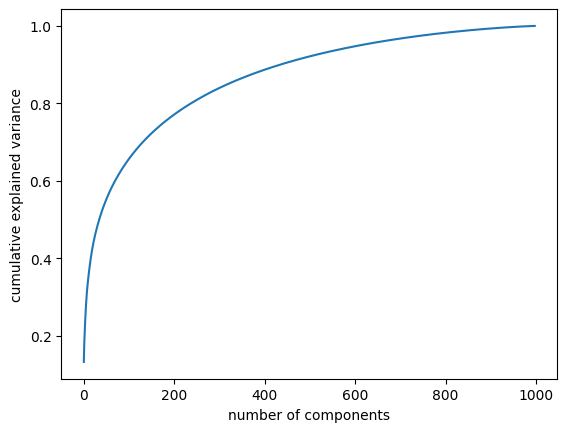

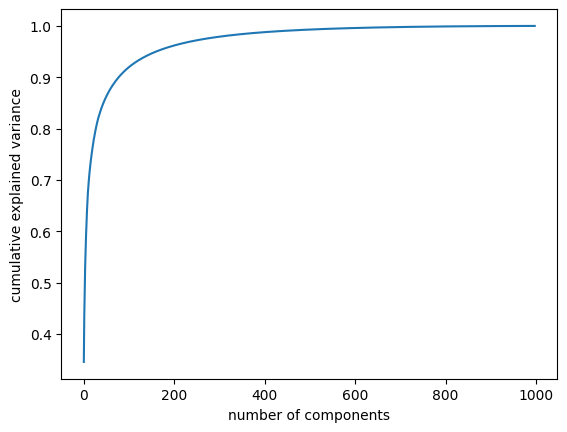

In [22]:
# Plot the cumulative explained variance for each covnet
pca_cumsum_plot(vgg16_pca)
pca_cumsum_plot(vgg19_pca)
pca_cumsum_plot(resnet50_pca)

Looking at the gaphs above, we can see that PCA can explain almost all the variance in as many dimensions as there are samples.

#### It is also interesting to note the difference in shape between the VGG graphs and the ResNet one. This is probably due to the fact that ResNet only had 2048 dimensions to start with, while VGGs had 25,088

In [23]:
# PCA transformations of covnet outputs
vgg16_output_pca = vgg16_pca.transform(vgg16_output)
vgg19_output_pca = vgg19_pca.transform(vgg19_output)
resnet50_output_pca = resnet50_pca.transform(resnet50_output)

#### Fitting KMeans models to the PCA outputs of the CNN models

In [24]:
# Let's pass the data into the algorithm and predict who lies in which cluster. 
# Since we're using the same data that we trained it on, this should give us the training results.

# Here we create and fit a KMeans model with the PCA outputs
print("KMeans (PCA): \n")

a = len(codes)
print("VGG16")
K_vgg16_pca = create_train_kmeans(vgg16_output_pca, a)

print("\nVGG19")
K_vgg19_pca = create_train_kmeans(vgg19_output_pca, a)

print("\nResNet50")
K_resnet50_pca = create_train_kmeans(resnet50_output_pca, a)

KMeans (PCA): 

VGG16
Training took 2.108546733856201 seconds

VGG19
Training took 0.12276244163513184 seconds

ResNet50
Training took 0.12049055099487305 seconds


In [25]:
# Let's also create models for the covnet outputs without PCA for comparison
print("KMeans: \n")
print(a)
print("VGG16:")
K_vgg16 = create_train_kmeans(vgg16_output, a)

print("\nVGG19:")
K_vgg19 = create_train_kmeans(vgg19_output, a)

print("\nResNet50:")
K_resnet50 = create_train_kmeans(resnet50_output, a)


KMeans: 

6
VGG16:
Training took 2.701139450073242 seconds

VGG19:
Training took 2.734070062637329 seconds

ResNet50:
Training took 9.76521897315979 seconds


In [26]:
# Now we get the cluster model predictions

# KMeans with PCA outputs
k_vgg16_pred_pca = K_vgg16_pca.predict(vgg16_output_pca)
k_vgg19_pred_pca = K_vgg19_pca.predict(vgg19_output_pca)
k_resnet50_pred_pca = K_resnet50_pca.predict(resnet50_output_pca)

# KMeans with CovNet outputs
k_vgg16_pred = K_vgg16.predict(vgg16_output)
k_vgg19_pred = K_vgg19.predict(vgg19_output)
k_resnet50_pred = K_resnet50.predict(resnet50_output)


In [27]:
# Cluster counting for VGG16 Means
vgg16_cluster_df, vgg16_cluster_count = cluster_label_count(k_vgg16_pred, y_train)
vgg16_cluster_df_pca, vgg16_cluster_count_pca = cluster_label_count(k_vgg16_pred_pca, y_train)

# VGG19 KMeans
vgg19_cluster_df, vgg19_cluster_count = cluster_label_count(k_vgg19_pred, y_train)
vgg19_cluster_df_pca, vgg19_cluster_count_pca = cluster_label_count(k_vgg19_pred_pca, y_train)

# ResNet50 KMeans
resnet_cluster_df, resnet_cluster_count = cluster_label_count(k_resnet50_pred, y_train)
resnet_cluster_df_pca, resnet_cluster_count_pca = cluster_label_count(k_resnet50_pred_pca, y_train)



In [28]:
print("KMeans VGG16 (PCA): ")
vgg16_cluster_df_pca

KMeans VGG16 (PCA): 


,0,1,2,3,4,5
carton,0,0,0,33,0,56
plant,77,3,131,23,0,0
glass bottle,2,58,2,25,0,0
paper,0,2,0,25,0,162
plastic bottle,14,53,2,21,1,0
food,9,3,113,7,176,0


In [29]:
print("KMeans VGG19: ")
vgg19_cluster_df

KMeans VGG19: 


,0,1,2,3,4,5
carton,2,72,1,0,1,13
plant,170,0,4,4,56,0
glass bottle,0,9,0,62,16,0
paper,1,60,0,1,1,126
plastic bottle,4,1,0,65,20,1
food,50,1,98,2,157,0


In [30]:
print("KMeans VGG19 (PCA): ")
vgg19_cluster_df_pca

KMeans VGG19 (PCA): 


,0,1,2,3,4,5
carton,2,72,1,0,1,13
plant,170,0,4,4,56,0
glass bottle,0,9,0,62,16,0
paper,1,60,0,1,1,126
plastic bottle,4,1,0,65,20,1
food,50,1,98,2,157,0


In [31]:
print("Kmeans Resnet50 (PCA): ")
resnet_cluster_df_pca

Kmeans Resnet50 (PCA): 


,0,1,2,3,4,5
carton,6,3,15,6,21,38
plant,57,1,54,18,11,93
glass bottle,1,0,29,0,4,53
paper,24,22,26,38,38,41
plastic bottle,6,0,16,0,4,65
food,39,0,69,0,0,200


In [41]:
# Assuming k_vgg16_pred_pca, k_vgg19_pred_pca, k_resnet50_pred_pca, and y_train are already defined
# Get cluster codes based on max label count
vgg16_cluster_code_pca = get_max_label_per_cluster(vgg16_cluster_count_pca)
vgg16_cluster_code = get_max_label_per_cluster(vgg16_cluster_count)
vgg19_cluster_code_pca = get_max_label_per_cluster(vgg19_cluster_count_pca)
vgg19_cluster_code = get_max_label_per_cluster(vgg19_cluster_count)
resnet_cluster_code_pca = get_max_label_per_cluster(resnet_cluster_count_pca)
resnet_cluster_code = get_max_label_per_cluster(resnet_cluster_count)


# Predict codes
vgg16_pred_codes_pca = [vgg16_cluster_code_pca[x] for x in k_vgg16_pred_pca]
vgg16_pred_codes = [vgg16_cluster_code_pca[x] for x in k_vgg16_pred]
vgg19_pred_codes_pca = [vgg19_cluster_code_pca[x] for x in k_vgg19_pred_pca]
vgg19_pred_codes = [vgg19_cluster_code_pca[x] for x in k_vgg19_pred]
resnet_pred_codes_pca = [resnet_cluster_code_pca[x] for x in k_resnet50_pred_pca]
resnet_pred_codes = [resnet_cluster_code_pca[x] for x in k_resnet50_pred]

# Function to print scores
from sklearn.metrics import accuracy_score, f1_score


# Print the scores
print("KMeans VGG16  ", print_scores(y_train, vgg16_pred_codes))
print("KMeans VGG16 (PCA)",print_scores(y_train, vgg16_pred_codes_pca))
print("KMeans VGG19 ", print_scores(y_train, vgg19_pred_codes))
print("KMeans VGG19 (PCA)", print_scores(y_train, vgg19_pred_codes_pca))
print("KMeans ResNet ", print_scores(y_train, resnet_pred_codes))
print("KMeans ResNet (PCA)", print_scores(y_train, resnet_pred_codes_pca))


KMeans VGG16   
	F1 Score: 0.51554028   |   Accuracy: 0.63827655
KMeans VGG16 (PCA) 
	F1 Score: 0.51554028   |   Accuracy: 0.63827655
KMeans VGG19  
	F1 Score: 0.57872412   |   Accuracy: 0.68937876
KMeans VGG19 (PCA) 
	F1 Score: 0.57872412   |   Accuracy: 0.68937876
KMeans ResNet  
	F1 Score: 0.23283326   |   Accuracy: 0.42484970
KMeans ResNet (PCA) 
	F1 Score: 0.23283326   |   Accuracy: 0.42484970


In [33]:
print(vgg16_cluster_code_pca)

['plant', 'glass bottle', 'plant', 'carton', 'food', 'paper']


#### note:

1. The scores (and cluster counts) of PCA and non-PCA transformed outputs are exactly the same. Since we fixed all random states, with the only difference being the inputs, we can see that PCA-transformed data adequately represents the original data while givig us faster training times and lower memory usage.

2. The clusters for PCA and non-PCA transformed data are exactly in the same order.

In [34]:
#all parameters relate to vgg16 mentioned in the above codeblock
# vgg16_model = keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3)) 
# vgg16_output = covnet_transform(vgg16_model, X_train)
# vgg16_pca = create_fit_PCA(vgg16_output)
# vgg16_output_pca = vgg16_pca.transform(vgg16_output)
K_vgg16_pca2 = create_train_kmeans(vgg16_output_pca, 50)
k_vgg16_pred_pca2 = K_vgg16_pca2.predict(vgg16_output_pca)
vgg16_cluster_df_pca2, vgg16_cluster_count_pca2 = cluster_label_count(k_vgg16_pred_pca2, y_train)
vgg16_cluster_code_pca2 = get_max_label_per_cluster(vgg16_cluster_count_pca2)
vgg16_pred_codes_pca2 = [vgg16_cluster_code_pca2[x] for x in k_vgg16_pred_pca2]

print("KMeans VGG16 (PCA)",print_scores(y_train, vgg16_pred_codes_pca2))

Training took 0.9494125843048096 seconds
KMeans VGG16 (PCA) 
	F1 Score: 0.76194896   |   Accuracy: 0.81663327


In [36]:
class_names_dict= {0: 'carton', 1: 'food', 2: 'glass bottle', 3: 'paper', 4: 'plant', 5: 'plastic bottle'}

c:\Users\buing\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\buing\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\buing\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

                precision    recall  f1-score   support

        carton       0.25      0.37      0.30        89
          food       0.99      0.57      0.73       308
  glass bottle       0.49      0.67      0.56        87
         paper       0.74      0.86      0.80       189
         plant       0.59      0.89      0.71       234
plastic bottle       0.00      0.00      0.00        91

      accuracy                           0.64       998
     macro avg       0.51      0.56      0.52       998
  weighted avg       0.65      0.64      0.62       998



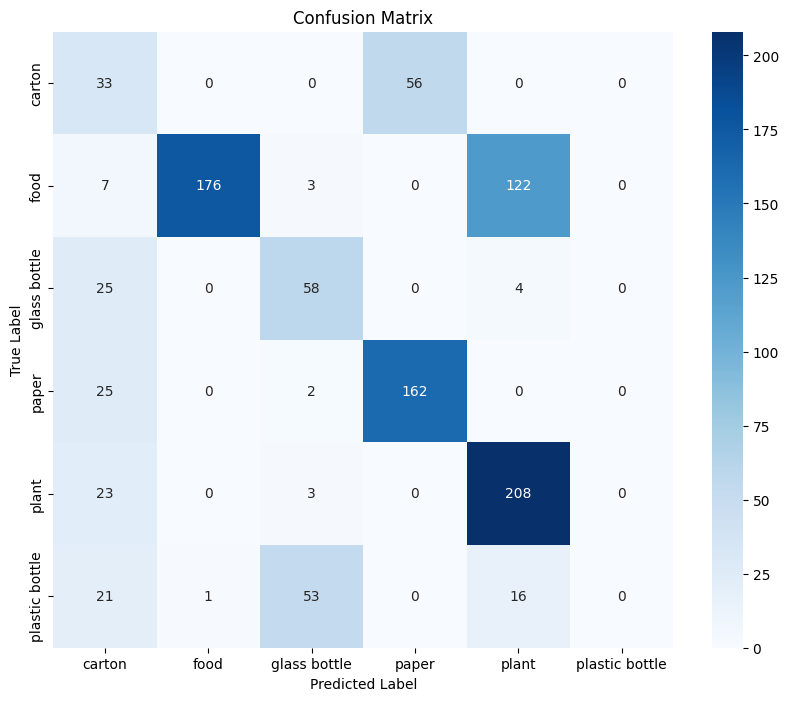

In [37]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Compute the confusion matrix

cm = confusion_matrix(y_train, vgg16_pred_codes_pca)
print(classification_report(y_train, vgg16_pred_codes_pca))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
        xticklabels=[class_names_dict[label] for label in sorted(class_names_dict.keys())], 
        yticklabels=[class_names_dict[label] for label in sorted(class_names_dict.keys())])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

                precision    recall  f1-score   support

        carton       0.79      0.63      0.70        89
          food       0.86      0.92      0.89       308
  glass bottle       0.78      0.53      0.63        87
         paper       0.84      0.88      0.86       189
         plant       0.82      0.86      0.84       234
plastic bottle       0.63      0.66      0.65        91

      accuracy                           0.82       998
     macro avg       0.79      0.75      0.76       998
  weighted avg       0.81      0.82      0.81       998



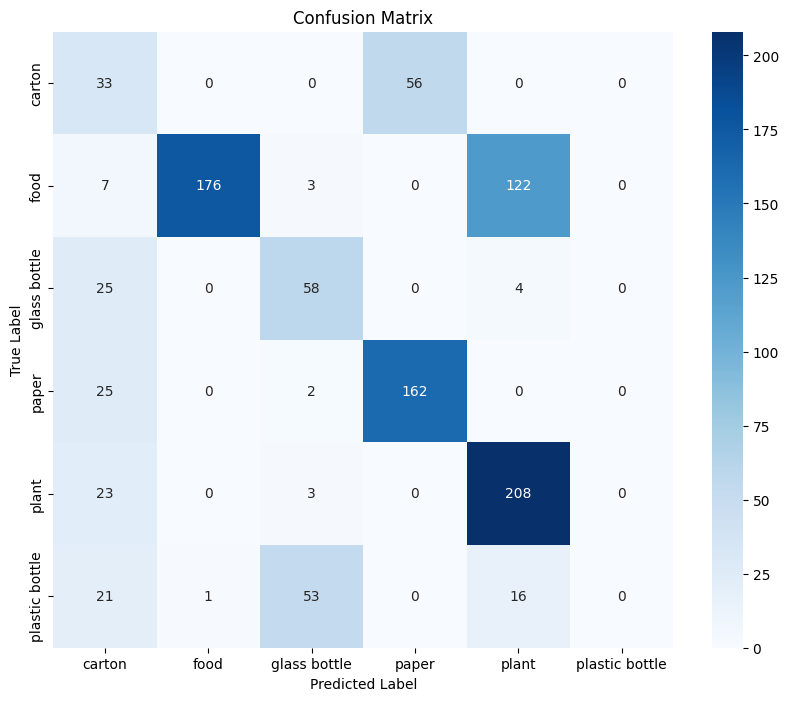

In [38]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Compute the confusion matrix

conf_matrix = confusion_matrix(y_train, vgg16_pred_codes_pca2)
print(classification_report(y_train, vgg16_pred_codes_pca2))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
        xticklabels=[class_names_dict[label] for label in sorted(class_names_dict.keys())], 
        yticklabels=[class_names_dict[label] for label in sorted(class_names_dict.keys())])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

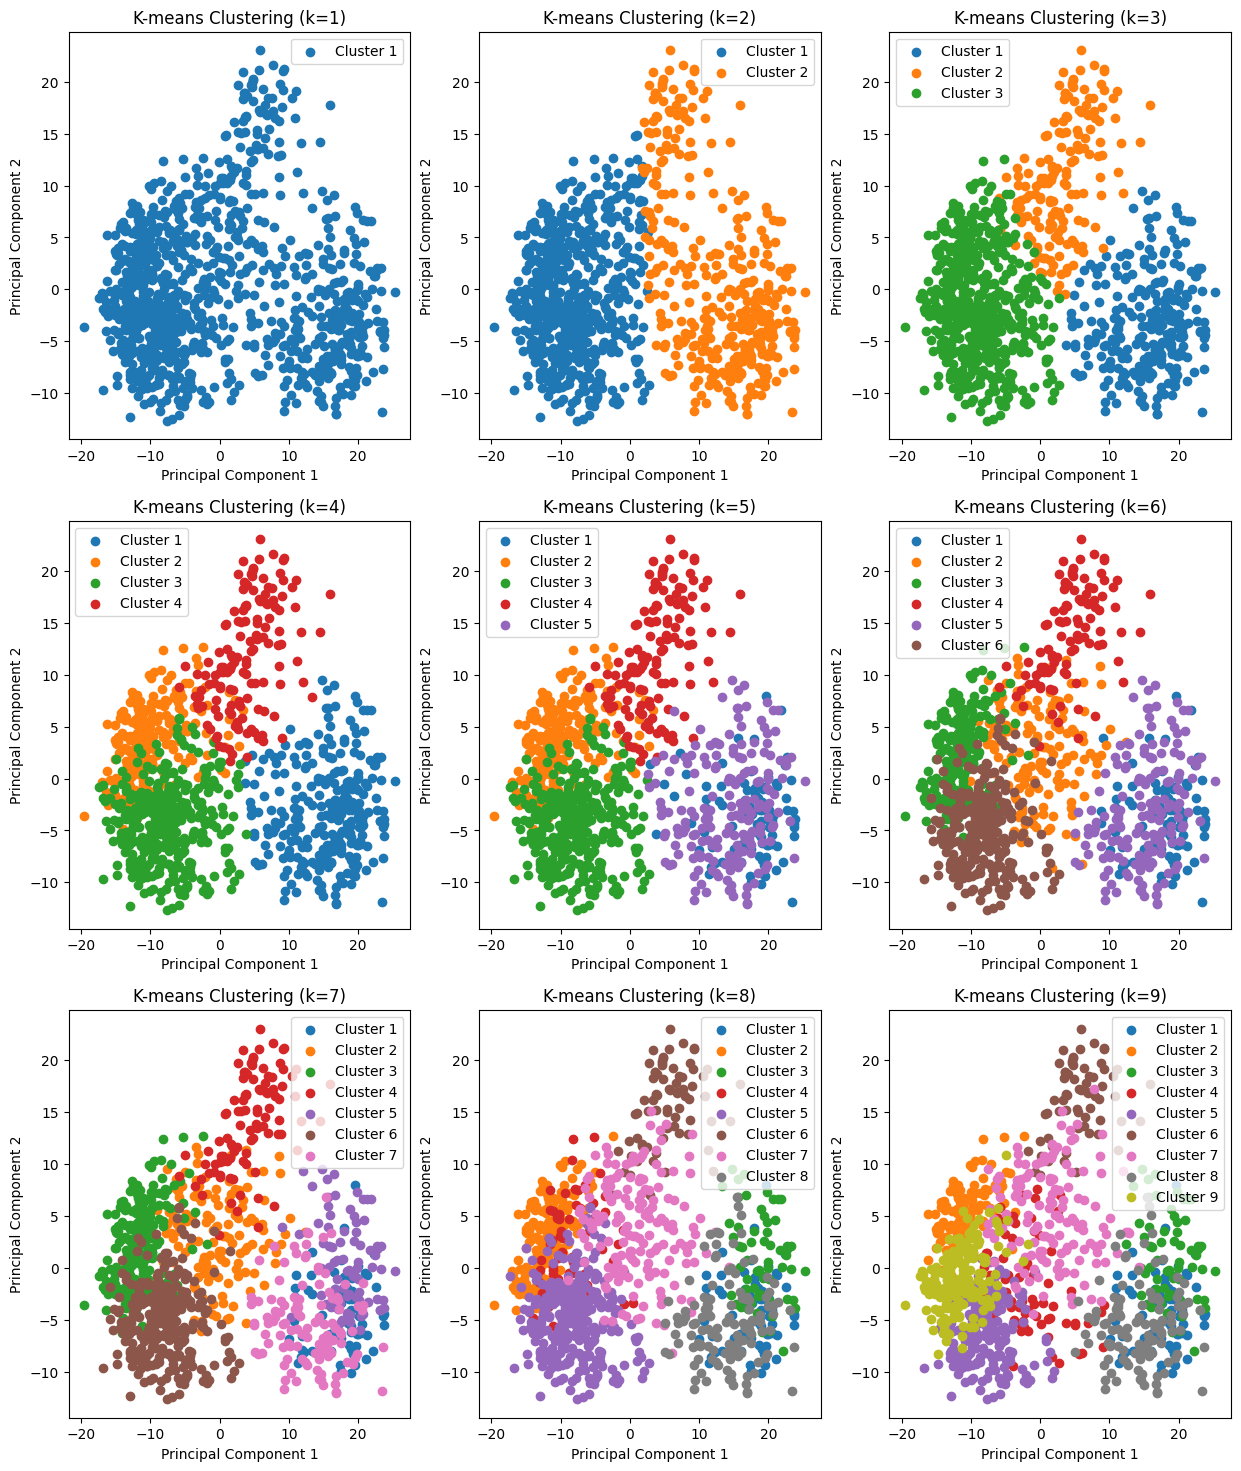

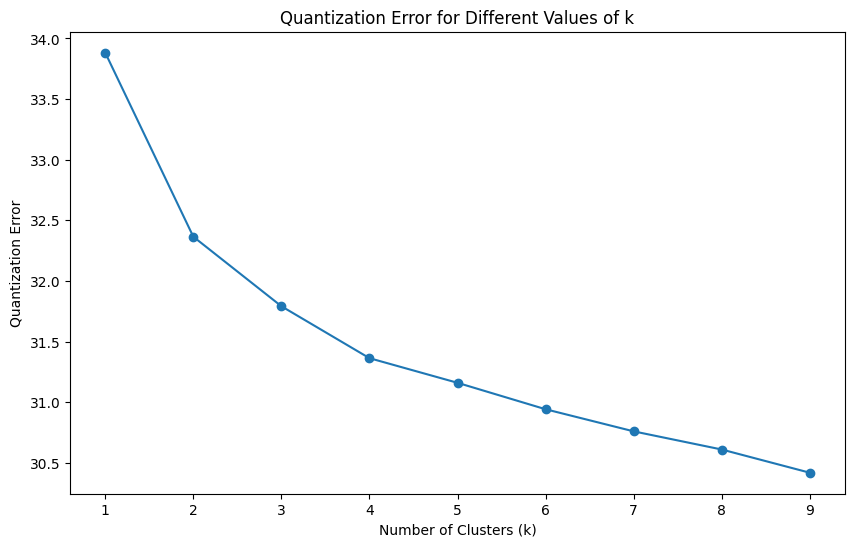

In [39]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=3)
pca_data = pca.fit_transform(vgg16_output_pca)

# Define the range of k values
k_values = range(1, 10)

# List to store quantization error values
quantization_error_values = []

# Create subplots for clustering results
fig, axs = plt.subplots(3, 3, figsize=(15, 18))
axs = axs.flatten()

# Perform K-means clustering and plot the clusters for each k
for i, k in enumerate(k_values):
    kmeans = KMeans(n_clusters=k, random_state=0)
    K_vgg16_pca3 = kmeans.fit(vgg16_output_pca)
    k_vgg16_pred_pca3 = K_vgg16_pca3.predict(vgg16_output_pca)
    vgg16_cluster_df_pca3, vgg16_cluster_count_pca3 = cluster_label_count(k_vgg16_pred_pca3, y_train)
    vgg16_cluster_code_pca3 = get_max_label_per_cluster(vgg16_cluster_count_pca3)
    vgg16_pred_codes_pca3 = [vgg16_cluster_code_pca3[x] for x in k_vgg16_pred_pca3]   
    cluster_labels = kmeans.fit_predict(vgg16_output_pca)

    # Calculate quantization error
    quantization_error = np.sum(np.min(kmeans.transform(vgg16_output_pca), axis=1)) / vgg16_output_pca.shape[0]  # Corrected here
    quantization_error_values.append(quantization_error)
    
    axs[i].set_title(f'K-means Clustering (k={k})')
    for cluster in range(k):
        axs[i].scatter(pca_data[cluster_labels == cluster, 0], 
                       pca_data[cluster_labels == cluster, 1], 
                       label=f'Cluster {cluster + 1}')
    axs[i].set_xlabel('Principal Component 1')
    axs[i].set_ylabel('Principal Component 2')
    axs[i].legend()

# Plot quantization error values
plt.figure(figsize=(10, 6))
plt.plot(k_values, quantization_error_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Quantization Error')
plt.title('Quantization Error for Different Values of k')
plt.show()


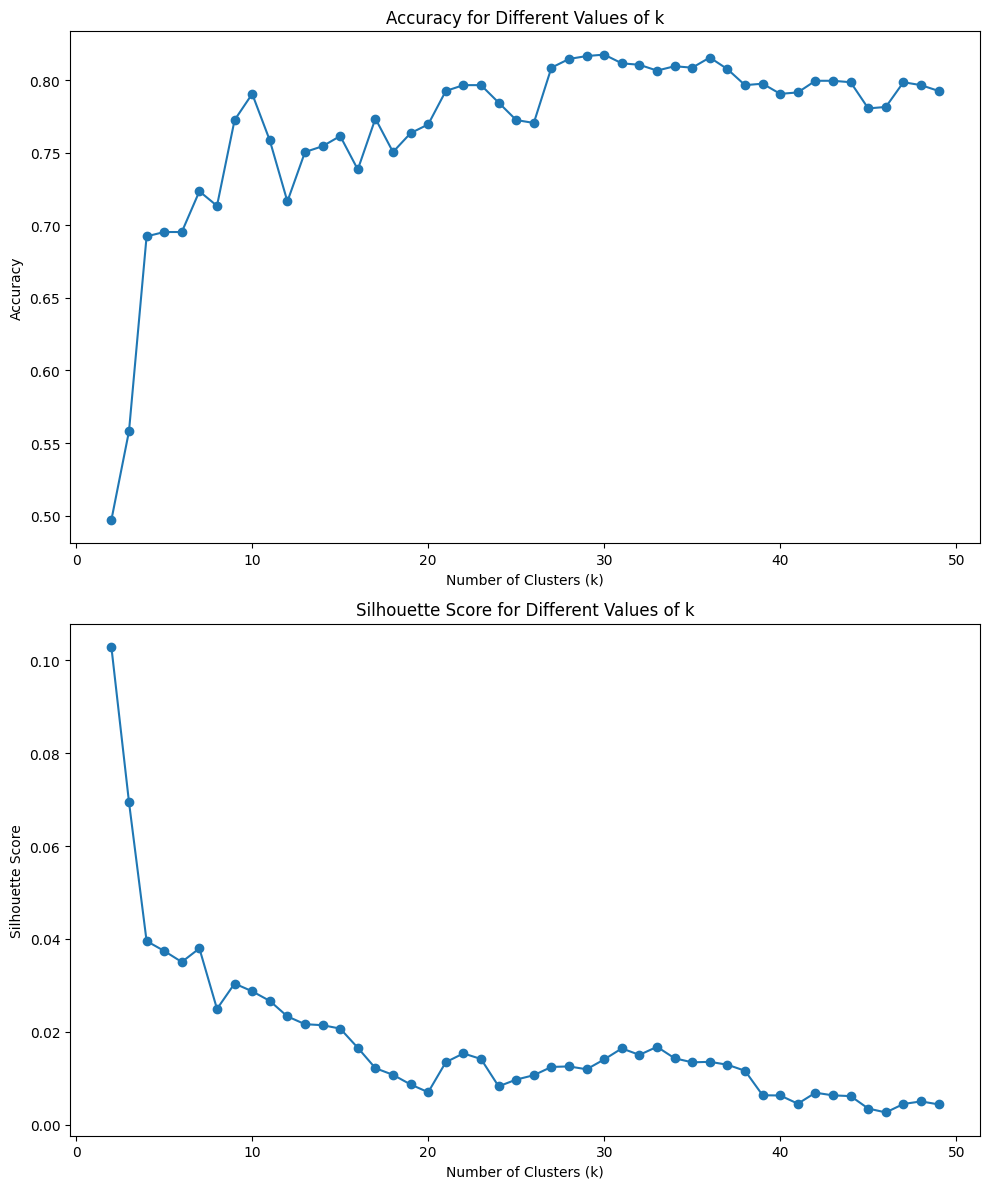

In [40]:
from sklearn.preprocessing import LabelEncoder
# Apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
pca_data = pca.fit_transform(vgg16_output)

# Define the range of k values
k_values = range(2, 50)  # Start from 2 as silhouette score requires at least 2 clusters

# Lists to store metrics values
accuracy_values = []
silhouette_score_values = []

# Create subplots for metrics results
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Encode labels to match clusters
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Perform K-means clustering and compute metrics for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    K_vgg16_pca3 = kmeans.fit(vgg16_output_pca)
    k_vgg16_pred_pca3 = K_vgg16_pca3.predict(vgg16_output_pca)
    vgg16_cluster_df_pca3, vgg16_cluster_count_pca3 = cluster_label_count(k_vgg16_pred_pca3, y_train)
    vgg16_cluster_code_pca3 = get_max_label_per_cluster(vgg16_cluster_count_pca3)
    vgg16_pred_codes_pca3 = [vgg16_cluster_code_pca3[x] for x in k_vgg16_pred_pca3]   
    cluster_labels = kmeans.fit_predict(vgg16_output_pca)

    # Calculate accuracy by mapping cluster labels to actual labels
    label_mapping = {}
    for cluster in range(k):
        mask = cluster_labels == cluster
        if np.sum(mask) == 0:
            continue
        most_common_label = np.bincount(y_train_encoded[mask]).argmax()
        label_mapping[cluster] = most_common_label

    predicted_labels = np.array([label_mapping[cluster] for cluster in cluster_labels])
    accuracy = accuracy_score(y_train_encoded, predicted_labels)
    accuracy_values.append(accuracy)
    
    # Calculate silhouette score
    silhouette = silhouette_score(vgg16_output_pca, cluster_labels)
    silhouette_score_values.append(silhouette)

# Plot accuracy values
axs[0].plot(k_values, accuracy_values, marker='o')
axs[0].set_xlabel('Number of Clusters (k)')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy for Different Values of k')

# Plot silhouette score values
axs[1].plot(k_values, silhouette_score_values, marker='o')
axs[1].set_xlabel('Number of Clusters (k)')
axs[1].set_ylabel('Silhouette Score')
axs[1].set_title('Silhouette Score for Different Values of k')

plt.tight_layout()
plt.show()
